In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Removed 0 invalid images.
Found 23843 files belonging to 34 classes.
Using 19075 files for training.
Found 23843 files belonging to 34 classes.
Using 4768 files for validation.
Epoch 1/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 119s 183ms/step - accuracy: 0.4348 - loss: 2.0722 - val_accuracy: 0.6898 - val_loss: 1.0536
Epoch 2/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.6780 - loss: 1.0789 - val_accuracy: 0.7116 - val_loss: 0.9580
Epoch 3/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7333 - loss: 0.8694 - val_accuracy: 0.7255 - val_loss: 0.9107
Epoch 4/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7609 - loss: 0.7668 - val_accuracy: 0.7318 - val_loss: 0.9013
Epoch 5/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7861 - loss: 0.6712 - val_accuracy: 0.7273 - val_loss: 0.9131
Epoch 6/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8034 - loss: 0.6073 - val_accuracy: 0.7364 - val_loss: 0.9310
Epoch 7/15
597/597 ━━━━━━━━━━━━━━━━━━━━ 8s 1

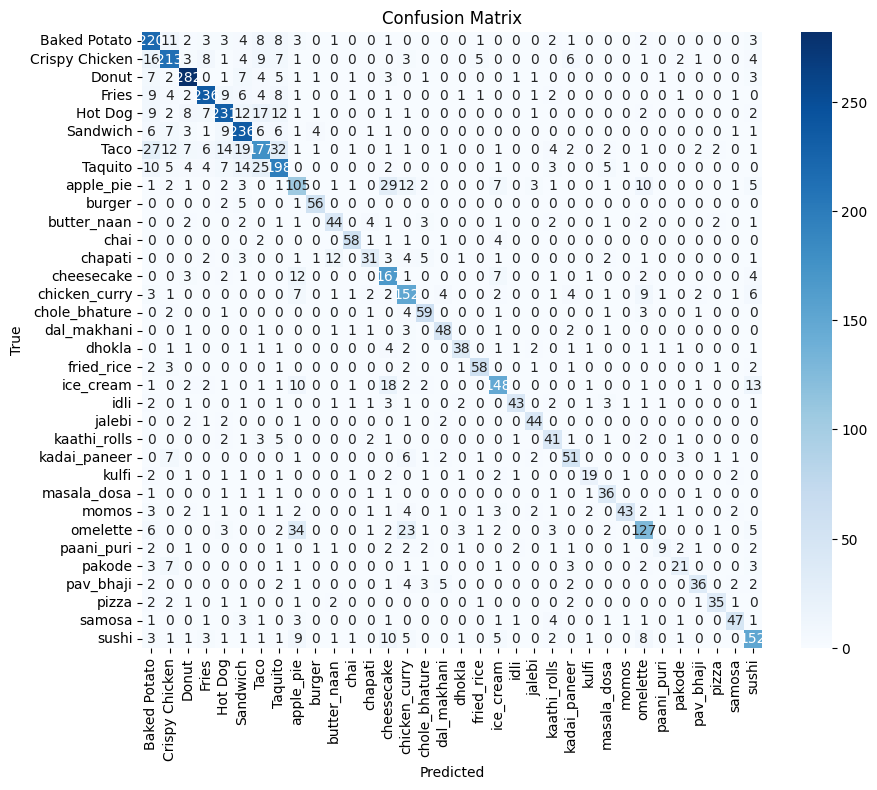

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os
import zipfile
import imghdr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


# Define dataset path
dataset_zip = "/content/drive/MyDrive/Food Classification dataset.zip"
dataset_dir = "/content/Food Classification dataset"

# Extract ZIP file
if not os.path.exists(dataset_dir):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/")

# Remove invalid/corrupted images
def clean_invalid_images(directory):
    removed = []
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            if imghdr.what(filepath) not in ['jpeg', 'png', 'bmp', 'gif']:
                os.remove(filepath)
                removed.append(filepath)
    print(f"Removed {len(removed)} invalid images.")
    return removed

clean_invalid_images(dataset_dir)

# Parameters
img_size = (128, 128)
batch_size = 32
seed = 123

# Split into training and validation datasets
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize the pixel values
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

# Load pre-trained base model
base_model = keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(128, 128, 3)
)
base_model.trainable = False

# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
epochs = 15
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Evaluate
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict
true_labels = []
predicted_labels = []
predicted_probs = []

for images, labels in val_ds:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    predicted_probs.extend(preds)
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Data directory (contains class folders directly)
data_dir = "/content/Food Classification dataset"

# 3. Transforms
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 4. Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# 5. Split into train and validation (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform to val dataset manually
val_dataset.dataset.transform = val_transforms

# 6. Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. Define a simple CNN from scratch
class FoodCNN(nn.Module):
    def __init__(self, num_classes):
        super(FoodCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

num_classes = len(full_dataset.classes)
model = FoodCNN(num_classes).to(device)

# 8. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 9. Training loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# 10. Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 - Train Loss: 2.9111 - Val Loss: 2.7036 - Val Acc: 21.58%
Epoch 2/10 - Train Loss: 2.5030 - Val Loss: 2.3978 - Val Acc: 29.52%
Epoch 3/10 - Train Loss: 2.1751 - Val Loss: 2.2669 - Val Acc: 34.37%
Epoch 4/10 - Train Loss: 1.8322 - Val Loss: 2.2750 - Val Acc: 35.06%


In [6]:
import scipy.stats as stats # Importing the scipy.stats module and aliasing it as 'stats'

# Z-Test
z_stat, z_p_value = stats.ttest_1samp(predicted_labels - true_labels, 0)
print(f"Z-Test: Z={z_stat:.2f}, p-value={z_p_value:.4f}")

Z-Test: Z=-5.94, p-value=0.0000


In [7]:
# T-Test
t_stat, t_p_value = stats.ttest_rel(predicted_labels, true_labels)
print(f"T-Test: T={t_stat:.2f}, p-value={t_p_value:.4f}")


T-Test: T=-5.94, p-value=0.0000


In [8]:
# ANOVA Test
anova_stat, anova_p_value = stats.f_oneway(predicted_labels, true_labels)
print(f"ANOVA Test: F={anova_stat:.2f}, p-value={anova_p_value:.4f}")


ANOVA Test: F=7.32, p-value=0.0068


In [9]:
# Type 1 & Type 2 Errors
false_positives = np.sum((predicted_labels != true_labels) & (true_labels == 0))
false_negatives = np.sum((predicted_labels != true_labels) & (true_labels == 1))
total_samples = len(true_labels)

type1_error_rate = false_positives / total_samples
type2_error_rate = false_negatives / total_samples

print(f"Type 1 Error Rate: {type1_error_rate:.2f}")
print(f"Type 2 Error Rate: {type2_error_rate:.2f}")


Type 1 Error Rate: 0.01
Type 2 Error Rate: 0.01


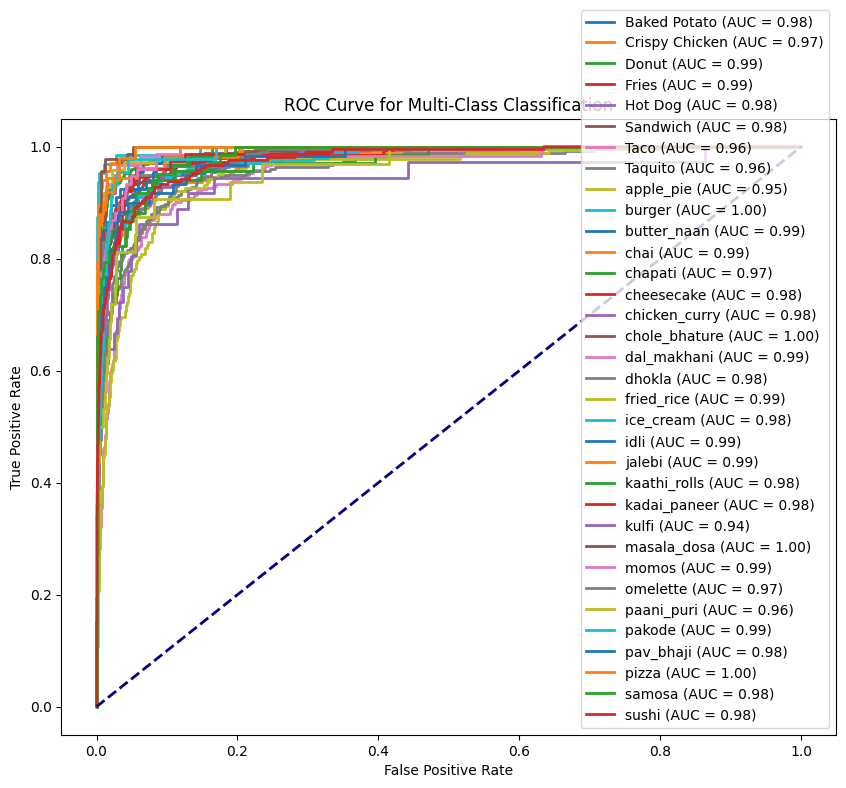

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize # Importing label_binarize

# ROC Curve (One-vs-Rest for Multi-Class)
# Binarize the labels for multi-class ROC curve
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))


# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve (Random Classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


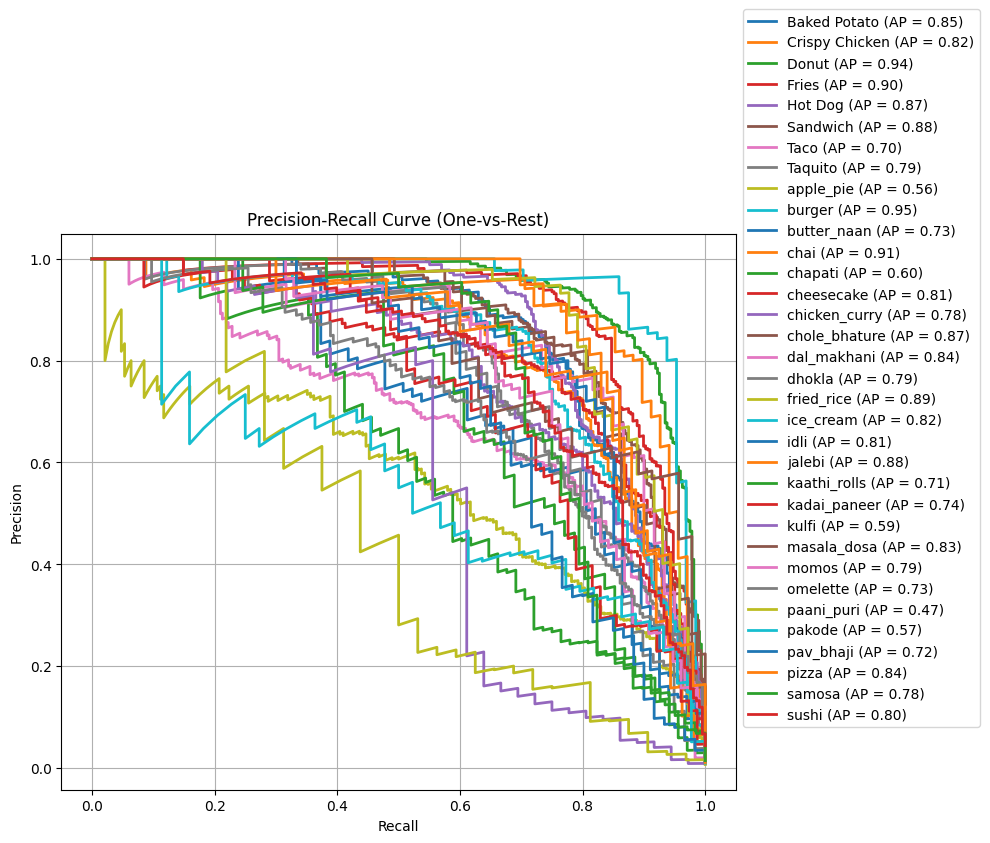

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], predicted_probs[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], predicted_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left", bbox_to_anchor=(1.0, 0.1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Mean Average Precision
mean_ap = average_precision_score(true_labels_bin, predicted_probs, average="macro")
print(f"Mean Average Precision (mAP): {mean_ap:.2f}")


Mean Average Precision (mAP): 0.78
